# Initial Path pattern generating

## Libraries

In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from queue import Queue
from queue import LifoQueue
import math

## Constants

In [2]:
IMG_WIDTH = 300
IMG_HEIGHT = 300
NO_DIGITS = 10
PLOT_WIDTH = 15
PLOT_HEIGHT = 6
LOW_RESOLUTION_IMG_SIZE = 10
LOW_RESOLUTION_IMG_MARGIN = 1
PAPER_SIZE = 0.8 # in meters
PAPER_CENTER = np.array([[-0.95],
                         [-1.1]])
PAPER_CX = PAPER_CENTER[0]
PAPER_CY = PAPER_CENTER[1]
ROBOT_HEAD_ANGLE = -math.pi/2
ROTATION_MATRIX = np.array([[np.cos(ROBOT_HEAD_ANGLE), np.sin(ROBOT_HEAD_ANGLE)],
                            [-np.sin(ROBOT_HEAD_ANGLE), np.cos(ROBOT_HEAD_ANGLE)]])
ROBOT_PAPER_CENTER = np.dot(ROTATION_MATRIX , PAPER_CENTER) # the coordinates in the robot frame
ROBOT_PAPER_CX = ROBOT_PAPER_CENTER[0]
ROBOT_PAPER_CY = ROBOT_PAPER_CENTER[1]

## Loading the set of premade images

In [3]:
image_path = '..\\data\\generated image numbers\\number'
!dir

 Volume in drive E is New Volume
 Volume Serial Number is 340B-A260

 Directory of E:\Arya\semester 10\project\main - gitted\offline_processing

05/23/2022  01:40 PM    <DIR>          .
05/23/2022  01:40 PM    <DIR>          ..
05/23/2022  10:50 AM    <DIR>          .ipynb_checkpoints
05/23/2022  10:56 AM            12,046 CNN_digit_detector.ipynb
05/23/2022  01:40 PM           214,311 PathGen_prototype.ipynb
               2 File(s)        226,357 bytes
               3 Dir(s)  492,528,197,632 bytes free


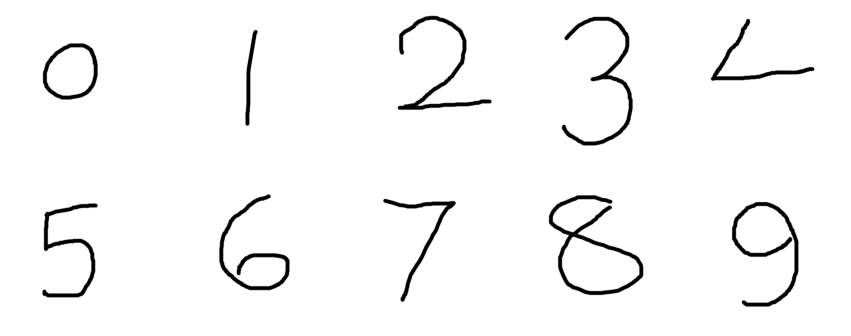

In [4]:
number_gray = np.zeros((NO_DIGITS, IMG_WIDTH ,IMG_HEIGHT))
for i in range (NO_DIGITS):
    number_image = cv.imread(image_path+' '+str(i)+'.png')
    number_gray[i] = cv.cvtColor(number_image, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
for i in range(NO_DIGITS):
    rs = NO_DIGITS/2
    col_no = int(rs)
    row_no = 2 + math.ceil(rs) - col_no # if there are remainings.
    plt.subplot(row_no, col_no, i+1)
    plt.imshow(number_gray[i],cmap='gray')
    plt.axis("off")

## Morphology Image Processing

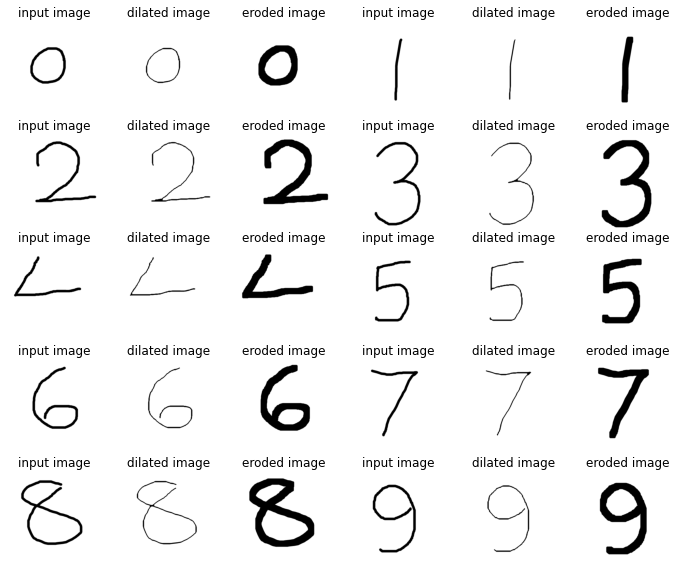

In [5]:
# Taking a matrix of size 5 as the kernel
kernel = np.ones((5,5), np.uint8)
img_dilation = np.zeros((NO_DIGITS, IMG_WIDTH, IMG_HEIGHT))
# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.

plt.figure(figsize=(12, 10))
for i in range(NO_DIGITS):
    img_erosion = cv.erode(number_gray[i], kernel, iterations=3)
    img_dilation[i, :, :] = cv.dilate(number_gray[i], kernel, iterations=1)
    plt.subplot(5,6, 3*i+1)
    plt.imshow(number_gray[i], cmap='gray')
    plt.title("input image")
    plt.axis("off")
    plt.subplot(5,6, 3*i+2)
    plt.imshow(img_dilation[i], cmap='gray')
    plt.title("dilated image")
    plt.axis("off")
    plt.subplot(5,6, 3*i+3)
    plt.imshow(img_erosion, cmap='gray')
    plt.title("eroded image")
    plt.axis("off")

## Change resolution


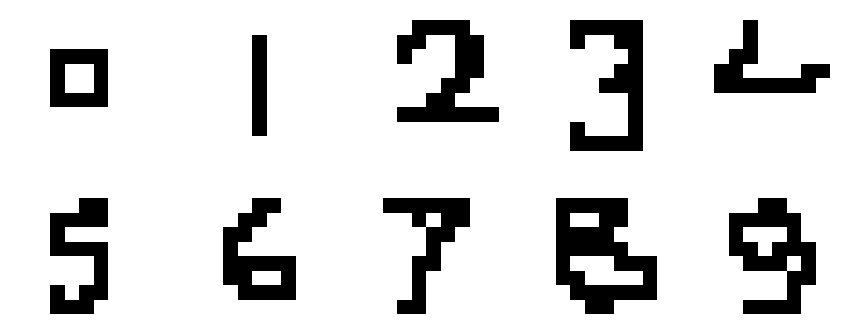

In [6]:
stride = 30 
new_imgw = int(IMG_WIDTH/stride)
new_imgh = int(IMG_HEIGHT/stride)
new_img = np.ones((NO_DIGITS, new_imgw, new_imgh))*255
# stride is always an odd number.

plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
for i in range(NO_DIGITS):
    my_img = img_dilation[i]
    # jump a 3,3 square and check for any black pixel within the area.

    for x in range(0, len(my_img), stride):
        for y in range(0, len(my_img[x]), stride):
            # stride is always an odd number.
            offset = int((stride-1)/2)
            new_x = int(x/30)
            new_y = int(y/30)
            has_black_vec = my_img[x-offset:x+offset+1,y-offset:y+offset+1]<50
            has_black_pxl = np.sum(has_black_vec)
            if(has_black_pxl>0): # has at least one black pixel
                new_img[i,new_x,new_y] = 0
      
    rs = NO_DIGITS/2
    col_no = int(rs)
    row_no = 2 + math.ceil(rs) - col_no # if there are remainings.
    plt.subplot(row_no, col_no, i+1)
    plt.imshow(new_img[i], cmap='gray')
    plt.axis('off')

## Find endpoints
finding the endpoints of each number with an algorithm.

### find the first black pixel
since the pixel might be isolated we have to iterate all of the pixels.

In [7]:
# # normalize values
# # norm_x = x/300
# # norm_y = y/300
# #TODO ^

# firstpxl_img = []
# visited_img = np.empty((10, 300, 300))
# # visit status
# unvisited_status = -4
# # -3 for not visited at all.
# # -2 for not iterated for location extraction phase.
# # any other value represents the pixel value intensity from the image.
# for i in range(10):
#   print('digit = ', i, '----------------')
#   BFSqueue = Queue()
#   myimg = img_dilation[i]
#   found = False
#   # 0 is balck and 255 is white
#   # anything under 50 pixel value is considered black here.
#   visited_img[i, :, :] = (myimg<50)*unvisited_status
#   firstpxl_img.append((0,0)) # default # to extend the length of the list.
#   for x in range(len(myimg)):
#     for y in range(len(myimg[x])):
#       max_black_num = -1 # the number of black pixels which are connected to this pixel.
#       # store each potential first black pixel point
#       # using BFS to determine all adjacent pixels.
#       if(visited_img[i, x,y]== unvisited_status): # is black and unvisited.
#         pxl_counter = 0
#         BFSqueue.put((x,y))
#         while(not BFSqueue.empty()):
#           xt,yt = BFSqueue.get()
#           for xtt in range(xt-1, xt+2):
#             for ytt in range(yt-1, yt+2):
#               if(xtt==xt and ytt==yt):
#                 continue
#               if(visited_img[i, xtt,ytt] == unvisited_status): # is black and unvisited.
#                 pxl_counter+=1
#                 visited_img[i, xtt,ytt] = unvisited_status + 1 # visited once
#                 BFSqueue.put((xtt,ytt))
#         if(max_black_num<pxl_counter):
#           print('number of black pixels connected to the first black pixel :', pxl_counter)
#           firstpxl_img[i] = (x,y)
#           max_black_num = pxl_counter

# print('------------------------------ done.')
# print('all recorded first black pixels', firstpxl_img)
# unvisited_status += 1

### Find last(lowest) black pixel
for drawing an eight digit we need the zero digit and to do that, we have to extract the zero digit image lowest position and highest position. the reason is we need two zero digits vertically connected to each other for drawing an eight.

In [8]:
# # in order to have more readability we extract lowest point for all digits,
# # regardless of the necessity.

# lowestpxl_img = []
# visited_lastpxl_img = np.empty((10, 300, 300)) # not to be confused with 
# # visit status
# # -3 for not visited at all.
# # -1 for not iterated for location extraction phase.
# # any other value represents the pixel value intensity from the image.
# for i in range(10):
#   print('digit = ', i, '----------------')
#   BFSqueue = Queue()
#   myimg = img_dilation[i]
#   found = False
#   # 0 is balck and 255 is white
#   # anything under 50 pixel value is considered black here.
#   visited_lastpxl_img[i, :, :] = (myimg<50)*-4
#   lowestpxl_img.append((0,0)) # default # to extend the length of the list.
#   for x in range(len(myimg)-1, -1, -1): # bottom-up
#     for y in range(len(myimg[x])-1, -1, -1): # left-right
#       max_black_num = -1 # the number of black pixels which are connected to this pixel.
#       # store each potential first black pixel point
#       # using BFS to determine all adjacent pixels.
#       if(visited_lastpxl_img[i, x,y]==-4): # is black and unvisited.
#         pxl_counter = 0
#         BFSqueue.put((x,y))
#         while(not BFSqueue.empty()):
#           xt,yt = BFSqueue.get()
#           for xtt in range(xt-1, xt+2):
#             for ytt in range(yt-1, yt+2):
#               if(xtt==xt and ytt==yt):
#                 continue
#               if(visited_lastpxl_img[i, xtt,ytt]==-4): # is black and unvisited.
#                 pxl_counter+=1
#                 visited_lastpxl_img[i, xtt,ytt] = -3 # visited once
#                 BFSqueue.put((xtt,ytt))
#         if(max_black_num<pxl_counter):
#           print('number of black pixels connected to the first black pixel :', pxl_counter)
#           lowestpxl_img[i] = (x,y)
#           max_black_num = pxl_counter
# print('------------------------------ done.')
# print('all recorded first black pixels', lowestpxl_img)

### global datastructures

In [9]:
# # previous datastructures.
# # BFSqueue
# # firstpxl_img
# # visited_img
# # unvisited_status
# # visited_lastpxl_img
# # img_dilation
# # need a queue to iterate the them, this is a BFS algorithm,
# # to iterate all the image and find the endpoints for each image using the visited_img matrix.
# endpoint_stack_img = []
# for i in range(10):
#   endpoint_stack_img.append(LifoQueue())

# # the endpoints at the end are saved in the endpoint stack as there are expected to be multiple endpoints.

### the algorithm
used BFS and visit matrix to determine the last point which is surrounded with -1 in visit matrix. and the last point will be marked as an endpoint
and it will be stored in the queue.

In [10]:
# for i in range(10):
#   x, y = firstpxl_img[i]
#   BFSqueue = Queue()
#   BFSqueue.put((x,y))
  
#   while(not BFSqueue.empty()):
#     has_unvisited_neighb = False
#     x,y = BFSqueue.get()
#     # check unvisited neighbors.
#     for xt in range(x-1, x+2):
#       for yt in range(y-1, y+2):
#         if(y==yt and x==xt):
#           visited_img[i, xt, yt] = unvisited_status+1
#           continue
#         if(visited_img[i, xt,yt]== unvisited_status):
#           has_unvisited_neighb = True;
#           BFSqueue.put((xt,yt))
#           visited_img[i, xt,yt] = unvisited_status+1
#           # i.e. visited for finding endpoints.

#     if(not has_unvisited_neighb):
#       endpoint_stack_img[i].put((x, y))

### warnings about the algorithm above:
- the sides of the image aren't checked due to being handcrafted so it is guaranteed that the black pixles aren't on the sides.

# Customizing each digit version 2

## the curviture the robot needs to draw and traverse.

In [11]:
pathq_digit = []
data = []
df = []
for i in range(NO_DIGITS):
    pathq_digit.append(Queue())
    data.append([])

In [12]:
def draw_char_img(i, new_img):
    print('----------------------------------------------------------- digit:', i)
    for x in range(len(new_img[i])):
        for y in range(len(new_img[i,x])):
            if(new_img[i,x,y]==0):
                print(' 0 ', end=', ')
            else:
                print(int(new_img[i, x, y]), end=', ')
        print('\n')

## Digit 0

In [13]:
i=0
draw_char_img(i, new_img)

----------------------------------------------------------- digit: 0
255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255,  0 ,  0 ,  0 ,  0 , 255, 255, 255, 

255, 255, 255,  0 , 255, 255,  0 , 255, 255, 255, 

255, 255, 255,  0 , 255, 255,  0 , 255, 255, 255, 

255, 255, 255,  0 ,  0 ,  0 ,  0 , 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 



In [14]:
pathq_digit[0].put((3,3))
pathq_digit[0].put((3,4))
pathq_digit[0].put((3,5))
pathq_digit[0].put((3,6))
pathq_digit[0].put((4,6))
pathq_digit[0].put((5,6))
pathq_digit[0].put((6,6))
pathq_digit[0].put((6,5))
pathq_digit[0].put((6,4))
pathq_digit[0].put((6,3))
pathq_digit[0].put((5,3))
pathq_digit[0].put((4,3))
pathq_digit[0].put((3,3))

data[i] = [(3,3),
         (3,4),
         (3,5),
         (3,6),
         (4,6),
         (5,6),
         (6,6),
         (6,5),
         (6,4),
         (6,3),
         (5,3),
         (4,3),
         (3,3)]

df.append(pd.DataFrame(data[i], columns=['x','y']))

## Digit 1

In [15]:
i=1
draw_char_img(i, new_img)

----------------------------------------------------------- digit: 1
255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255,  0 , 255, 255, 255, 255, 

255, 255, 255, 255, 255,  0 , 255, 255, 255, 255, 

255, 255, 255, 255, 255,  0 , 255, 255, 255, 255, 

255, 255, 255, 255, 255,  0 , 255, 255, 255, 255, 

255, 255, 255, 255, 255,  0 , 255, 255, 255, 255, 

255, 255, 255, 255, 255,  0 , 255, 255, 255, 255, 

255, 255, 255, 255, 255,  0 , 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 



In [16]:
# i = 1
for x in range(2, 9):
    pathq_digit[i].put((x,5))
    data[i].append((x,5))

df.append(pd.DataFrame(data[i], columns=['x','y']))

## Digit 2

In [17]:
i=2
draw_char_img(i, new_img)

----------------------------------------------------------- digit: 2
255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255,  0 ,  0 ,  0 ,  0 , 255, 255, 

255, 255, 255,  0 ,  0 , 255, 255,  0 ,  0 , 255, 

255, 255, 255,  0 , 255, 255, 255,  0 ,  0 , 255, 

255, 255, 255, 255, 255, 255, 255,  0 ,  0 , 255, 

255, 255, 255, 255, 255, 255,  0 ,  0 , 255, 255, 

255, 255, 255, 255, 255,  0 ,  0 , 255, 255, 255, 

255, 255, 255,  0 ,  0 ,  0 ,  0 ,  0 ,  0 ,  0 , 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 



In [18]:
# i = 2
pathq_digit[i].put((3,3))
pathq_digit[i].put((2,3))
for y in range(4,8):
    pathq_digit[i].put((1,i))
for x in range(2,5):
    pathq_digit[i].put((i,8))
pathq_digit[i].put((5,7))
pathq_digit[i].put((6,5))
for y in range(3, 10):
    pathq_digit[i].put((7,y))


data[i].append((3,3))
data[i].append((2,3))
for y in range(4,8):
    data[i].append((1,i))
for x in range(2,5):
    data[i].append((i,8))
data[i].append((5,7))
data[i].append((6,5))
for y in range(3, 10):
    data[i].append((7,y))

df.append(pd.DataFrame(data[i], columns=['x','y']))

## Digit 3

In [19]:
i=3
draw_char_img(i, new_img)

----------------------------------------------------------- digit: 3
255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255,  0 ,  0 ,  0 ,  0 ,  0 , 255, 255, 

255, 255, 255,  0 , 255, 255,  0 ,  0 , 255, 255, 

255, 255, 255, 255, 255, 255, 255,  0 , 255, 255, 

255, 255, 255, 255, 255, 255,  0 ,  0 , 255, 255, 

255, 255, 255, 255, 255,  0 ,  0 ,  0 , 255, 255, 

255, 255, 255, 255, 255, 255, 255,  0 , 255, 255, 

255, 255, 255, 255, 255, 255, 255,  0 , 255, 255, 

255, 255, 255,  0 , 255, 255, 255,  0 , 255, 255, 

255, 255, 255,  0 ,  0 ,  0 ,  0 ,  0 , 255, 255, 



In [20]:
# i = 3
pathq_digit[i].put((2,3))
for y in range(4,7):
    pathq_digit[i].put((1,y))
for x in range(2,5):
    pathq_digit[i].put((x,7))
pathq_digit[i].put((5,5))
for x in range(6,9):
    pathq_digit[i].put((x,7))
for y in range(6,3,-1):
    pathq_digit[i].put((9,y))

data[i].append((2,3))
for y in range(4,7):
    data[i].append((1,y))
for x in range(2,5):
    data[i].append((x,7))
data[i].append((5,5))
for x in range(6,9):
    data[i].append((x,7))
for y in range(6,3,-1):
    data[i].append((9,y))

df.append(pd.DataFrame(data[i], columns=['x','y']))

## Digit 4

In [21]:
i=4
draw_char_img(i, new_img)

----------------------------------------------------------- digit: 4
255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255,  0 , 255, 255, 255, 255, 255, 255, 

255, 255, 255,  0 , 255, 255, 255, 255, 255, 255, 

255, 255,  0 ,  0 , 255, 255, 255, 255, 255, 255, 

255,  0 ,  0 , 255, 255, 255, 255,  0 ,  0 , 255, 

255,  0 ,  0 ,  0 ,  0 ,  0 ,  0 ,  0 , 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 



In [22]:
# i = 4
pathq_digit[i].put((1,3))
pathq_digit[i].put((2,3))
pathq_digit[i].put((3,2))
pathq_digit[i].put((4,1))
for y in range(1, 8):
    pathq_digit[i].put((5,y))

data[i].append((1,3))
data[i].append((2,3))
data[i].append((3,2))
data[i].append((4,1))
for y in range(1, 8):
    data[i].append((5,y))

df.append(pd.DataFrame(data[i], columns=['x','y']))

## Digit 5

In [23]:
i=5
draw_char_img(i, new_img)

----------------------------------------------------------- digit: 5
255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255,  0 ,  0 , 255, 255, 255, 

255, 255, 255,  0 ,  0 ,  0 ,  0 , 255, 255, 255, 

255, 255, 255,  0 , 255, 255, 255, 255, 255, 255, 

255, 255, 255,  0 ,  0 ,  0 ,  0 , 255, 255, 255, 

255, 255, 255, 255, 255, 255,  0 , 255, 255, 255, 

255, 255, 255, 255, 255, 255,  0 , 255, 255, 255, 

255, 255, 255,  0 , 255,  0 ,  0 , 255, 255, 255, 

255, 255, 255,  0 ,  0 ,  0 , 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 



In [24]:
# i = 5
pathq_digit[i].put((1,6))
pathq_digit[i].put((1,5))
pathq_digit[i].put((2,4))
pathq_digit[i].put((2,3))
for x in range(2,5):
      pathq_digit[i].put((x,3))
for y in range(3,7):
      pathq_digit[i].put((4,y))
for x in range(5,8):
      pathq_digit[i].put((x,6))
for y in range(5,2,-1):
      pathq_digit[i].put((8,y))
pathq_digit[i].put((7,2))

data[i].append((1,6))
data[i].append((1,5))
data[i].append((2,4))
data[i].append((2,3))
for x in range(2,5):
      data[i].append((x,3))
for y in range(3,7):
      data[i].append((4,y))
for x in range(5,8):
      data[i].append((x,6))
for y in range(5,2,-1):
      data[i].append((8,y))
data[i].append((7,2))

df.append(pd.DataFrame(data[i], columns=['x','y']))

## Digit 6

In [25]:
i=6
draw_char_img(i, new_img)

----------------------------------------------------------- digit: 6
255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255,  0 ,  0 , 255, 255, 255, 

255, 255, 255, 255,  0 ,  0 , 255, 255, 255, 255, 

255, 255, 255,  0 ,  0 , 255, 255, 255, 255, 255, 

255, 255, 255,  0 , 255, 255, 255, 255, 255, 255, 

255, 255, 255,  0 ,  0 ,  0 ,  0 ,  0 , 255, 255, 

255, 255, 255,  0 ,  0 , 255, 255,  0 , 255, 255, 

255, 255, 255, 255,  0 ,  0 ,  0 ,  0 , 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 



In [26]:
# i = 6
pathq_digit[i].put((1,6))
pathq_digit[i].put((1,5))
pathq_digit[i].put((2,4))
for x in range(3,7):
    pathq_digit[i].put((x,3))
for y in range(4, 8):
    pathq_digit[i].put((7,y))
for x in range(7,4,-1):
    pathq_digit[i].put((x,7))
for y in range(6,3,-1):
    pathq_digit[i].put((5,y))

data[i].append((1,6))
data[i].append((1,5))
data[i].append((2,4))
for x in range(3,7):
    data[i].append((x,3))
for y in range(4, 8):
    data[i].append((7,y))
for x in range(7,4,-1):
    data[i].append((x,7))
for y in range(6,3,-1):
    data[i].append((5,y))

df.append(pd.DataFrame(data[i], columns=['x','y']))

## Digit 7

In [27]:
i=7
draw_char_img(i, new_img)

----------------------------------------------------------- digit: 7
255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255,  0 ,  0 ,  0 ,  0 ,  0 ,  0 , 255, 255, 

255, 255, 255, 255,  0 , 255,  0 ,  0 , 255, 255, 

255, 255, 255, 255, 255,  0 ,  0 , 255, 255, 255, 

255, 255, 255, 255, 255,  0 , 255, 255, 255, 255, 

255, 255, 255, 255,  0 ,  0 , 255, 255, 255, 255, 

255, 255, 255, 255,  0 , 255, 255, 255, 255, 255, 

255, 255, 255, 255,  0 , 255, 255, 255, 255, 255, 

255, 255, 255,  0 ,  0 , 255, 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 



In [28]:
# i = 7
for y in range(2, 8):
    pathq_digit[i].put((1,y))
pathq_digit[i].put((2,6))
pathq_digit[i].put((4,5))
for x in range(6,9):
    pathq_digit[i].put((x,4))

for y in range(2, 8):
    data[i].append((1,y))
data[i].append((2,6))
data[i].append((4,5))
for x in range(6,9):
    data[i].append((x,4))

df.append(pd.DataFrame(data[i], columns=['x','y']))

## Digit 8

In [29]:
i=8
draw_char_img(i, new_img)

----------------------------------------------------------- digit: 8
255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255,  0 ,  0 ,  0 ,  0 ,  0 , 255, 255, 255, 

255, 255,  0 , 255, 255,  0 ,  0 , 255, 255, 255, 

255, 255,  0 ,  0 ,  0 ,  0 , 255, 255, 255, 255, 

255, 255,  0 ,  0 ,  0 ,  0 ,  0 , 255, 255, 255, 

255, 255,  0 , 255, 255, 255,  0 ,  0 ,  0 , 255, 

255, 255,  0 ,  0 , 255, 255, 255, 255,  0 , 255, 

255, 255, 255,  0 ,  0 ,  0 ,  0 ,  0 ,  0 , 255, 

255, 255, 255, 255,  0 ,  0 , 255, 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 



In [30]:
# i = 8
pathq_digit[i].put((3,3))
pathq_digit[i].put((2,2))
for y in range(2,7):
    pathq_digit[i].put((1,y))
pathq_digit[i].put((2,6))
pathq_digit[i].put((3,5))
pathq_digit[i].put((4,3))
pathq_digit[i].put((5,2))
pathq_digit[i].put((6,2))
pathq_digit[i].put((7,3))
pathq_digit[i].put((8,4))
pathq_digit[i].put((8,5))
pathq_digit[i].put((7,6))
pathq_digit[i].put((7,7))
pathq_digit[i].put((6,8))
pathq_digit[i].put((5,8))
pathq_digit[i].put((5,7))
pathq_digit[i].put((4,5))

data[i].append((3,3))
data[i].append((2,2))
for y in range(2,7):
    data[i].append((1,y))
data[i].append((2,6))
data[i].append((3,5))
data[i].append((4,3))
data[i].append((5,2))
data[i].append((6,2))
data[i].append((7,3))
data[i].append((8,4))
data[i].append((8,5))
data[i].append((7,6))
data[i].append((7,7))
data[i].append((6,8))
data[i].append((5,8))
data[i].append((5,7))
data[i].append((4,5))

df.append(pd.DataFrame(data[i], columns=['x','y']))

## Digit 9

In [31]:
i=9
draw_char_img(i, new_img)

----------------------------------------------------------- digit: 9
255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 

255, 255, 255, 255,  0 ,  0 , 255, 255, 255, 255, 

255, 255,  0 ,  0 ,  0 ,  0 ,  0 , 255, 255, 255, 

255, 255,  0 , 255, 255, 255,  0 , 255, 255, 255, 

255, 255,  0 ,  0 , 255,  0 ,  0 ,  0 , 255, 255, 

255, 255, 255,  0 ,  0 ,  0 , 255,  0 , 255, 255, 

255, 255, 255, 255, 255, 255,  0 ,  0 , 255, 255, 

255, 255, 255, 255, 255, 255,  0 , 255, 255, 255, 

255, 255, 255,  0 ,  0 ,  0 ,  0 , 255, 255, 255, 

255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 



In [32]:
# i = 9
for y in range(5,2,-1):
    pathq_digit[i].put((5,y))
for x in range(4,1,-1):
    pathq_digit[i].put((x,2))
pathq_digit[i].put((2,3))
pathq_digit[i].put((1,4))
pathq_digit[i].put((1,5))
pathq_digit[i].put((2,6))
pathq_digit[i].put((3,6))
for x in range(4,7):
    pathq_digit[i].put((x,7))
pathq_digit[i].put((7,6))
for y in range(5,2,-1):
    pathq_digit[i].put((8,y))


for y in range(5,2,-1):
    data[i].append((5,y))
for x in range(4,1,-1):
    data[i].append((x,2))
data[i].append((2,3))
data[i].append((1,4))
data[i].append((1,5))
data[i].append((2,6))
data[i].append((3,6))
for x in range(4,7):
    data[i].append((x,7))
data[i].append((7,6))
for y in range(5,2,-1):
    data[i].append((8,y))

df.append(pd.DataFrame(data[i], columns=['x','y']))

## Export Data

In [33]:
def convert(x, y):
    x, y = y, x
    y = LOW_RESOLUTION_IMG_SIZE - y - 1
    scalar = PAPER_SIZE / (LOW_RESOLUTION_IMG_SIZE + 2*LOW_RESOLUTION_IMG_MARGIN)
    x+=1
    y+=1
    x*=scalar
    y*=scalar
    x+=-PAPER_SIZE/2 + ROBOT_PAPER_CX
    y+=-PAPER_SIZE/2 + ROBOT_PAPER_CY
    return x, y

In [34]:
# print(convert(4,4))
# print(convert(4.5,4.5))
# print(convert(5,5))
print(-PAPER_SIZE/2 + ROBOT_PAPER_CY)
print(PAPER_SIZE)
print(ROBOT_PAPER_CY)
# print(-PAPER_SIZE/2 + ROBOT_PAPER_CX)

[-1.35]
0.8
[-0.95]


In [35]:
for i in range(NO_DIGITS):
    ### swap columns
    # test below TODO
    # print('----------------- i =', i)
    tdf = df[i]
    # print(tdf, '\n')
    colList = list(tdf.columns)
    colList[0], colList[1] =  colList[1], colList[0]
    tdf = tdf[colList]
    tdf.rename(columns={'x': 'y',
                      'y': 'x'},
          inplace=True, errors='raise')
    tdf['y'] = LOW_RESOLUTION_IMG_SIZE - tdf['y'] - 1
    print(tdf, '\n')
    ### mapping to the real world coordinate system 
    scalar = PAPER_SIZE / (LOW_RESOLUTION_IMG_SIZE + 2*LOW_RESOLUTION_IMG_MARGIN)
    tdf += 1
    tdf *= scalar
    tdf['x'] += -PAPER_SIZE/2 + ROBOT_PAPER_CX
    tdf['y'] += -PAPER_SIZE/2 + ROBOT_PAPER_CY
    # print('scalar = ', scalar, '\n')
    print(tdf,'\n')
    ### save to file
    tdf.to_csv('..\\data\\path t numbers\\patht_Num_'+str(i)+'.csv')

    x  y
0   3  6
1   4  6
2   5  6
3   6  6
4   6  5
5   6  4
6   6  3
7   5  3
8   4  3
9   3  3
10  3  4
11  3  5
12  3  6 

           x         y
0   0.966667 -0.883333
1   1.033333 -0.883333
2   1.100000 -0.883333
3   1.166667 -0.883333
4   1.166667 -0.950000
5   1.166667 -1.016667
6   1.166667 -1.083333
7   1.100000 -1.083333
8   1.033333 -1.083333
9   0.966667 -1.083333
10  0.966667 -1.016667
11  0.966667 -0.950000
12  0.966667 -0.883333 

   x  y
0  5  7
1  5  6
2  5  5
3  5  4
4  5  3
5  5  2
6  5  1 

     x         y
0  1.1 -0.816667
1  1.1 -0.883333
2  1.1 -0.950000
3  1.1 -1.016667
4  1.1 -1.083333
5  1.1 -1.150000
6  1.1 -1.216667 

    x  y
0   3  6
1   3  7
2   2  8
3   2  8
4   2  8
5   2  8
6   8  7
7   8  7
8   8  7
9   7  4
10  5  3
11  3  2
12  4  2
13  5  2
14  6  2
15  7  2
16  8  2
17  9  2 

           x         y
0   0.966667 -0.883333
1   0.966667 -0.816667
2   0.900000 -0.750000
3   0.900000 -0.750000
4   0.900000 -0.750000
5   0.900000 -0.750000
6   1.3000

# explaining each digit pattern

## digit 0
### ; image of digit 0

there is no problem with this digit 

we build the pattern with center of each step in a queue.
## digit 1
### ; image of digit 1

there is no problem with this digit

there is also the option of making this pattern from the first point in the image.

we build the pattern with center of each step in a queue.
## digit 2
### ; image of digit 2 

there is no problem with this digit.

we build the pattern with center of each step in a queue.
## digit 3
### ; image of digit 3

there is no problem with this digit.

we build the pattern with center of each step.
## digit 4
### ; image of digit 4

the pattern for this digit first starts with a one pattern. and then it can be either started from the last or first position.

we build the pattern with center of each step in a queue.
## digit 5
### ; image of digit 5

there is no problem with this digit.

we build the pattern with the center of each step in a queue.
## digit 6
### ; image of digit 6

there is no problem with this digit.

there is also the option of starting the pattern generation from the first position instead.

we make the pattern with the center of each step in a queue.
## digit 7
### ; image of digit 7

there is no problem with this digit.

there is also the option of starting the pattern generated from the first position instead.

we make the pattern with the center of each step in queue.
## digit 8
### ; image of digit 8

THERE ARE HUGE PROBLEMS WITH THIS DIGIT, due to cross section in the pattern. and there are doubts about how we're are going to approach this and handle it.

### the suggestions for digit 8:

- first by handling it as two zero digits connected vertically.
- second by handling it like an adaptive curve sampling and connecting it like a graph together.

## digit 9
### ; image of digit 9

there are no problems for this digit.

we build the pattern from the last position, with center of each step in a queue.

# customizing pattern for each digit

## digit 0
without customization, saving the path from the stack into the queue.

Although in order to make the path linear we have to persue only one way in drawing and writing. so we use a modified version of BFS which is to visit the neighbouring pixles with priority, the priority is to select pixels in the right. if there aren't any, the pixel on the top will be chosen. if there is no pixel above the current one, the pixel on the botttom will be chosen. otherwise we'll head to the pixels located on the left.

In [36]:
# # previous datastructures.
# # BFSqueue
# # firstpxl_img
# # lowestpxl_img
# # visited_img
# # unvisited_status
# # visited_lastpxl_img
# # img_dilation
# # endpoint_stack_img

# i=0
# # number zero
# pathq = Queue()

# x, y = firstpxl_img[i]
# BFSqueue = Queue()
# BFSqueue.put((x,y))

# while(not BFSqueue.empty()):
#   has_unvisited_neighb = False
#   x,y = BFSqueue.get()

#   # setting boolean values to determine if there are any unvisited black pixels within each area listed below.
#   right_neighbs = visited_img[i,x-1:x+2,y+1] == unvisited_status
#   left_neighbs = visited_img[i,x-1:x+2,y-1] == unvisited_status

#   # right neighbours : (x+1,y+1) , (x,y+1) , (x-1,y+1)
#   visit_right = np.sum(right_neighbs)>0
#   # right neighbours : (x+1,y-1) , (x,y-1) , (x-1,y-1)
#   visit_left = np.sum(left_neighbs)>0

#   visit_top = visited_img[i,x-1,y] == unvisited_status
#   visit_bot = visited_img[i,x+1,y] == unvisited_status

#   if(visit_top):
#     visited_img[i,x-1,y] = unvisited_status+1
#     BFSqueue.put(x-1,y)
#     pathq.put((x-1,y))
#   elif(visit_bot):
#     visited_img[i,x+1,y] = unvisited_status+1
#     BFSqueue.put(x+1,y)
#     pathq.put(x+1,y)
#   if(visit_right): # if there were any unvisited black pixels on the right, focus on them.
#     for xt in range(x-1, x+2):
#       if(visited_img[i,xt,y+1]==unvisited_status):
#         visited_img[i,xt,y+1] = unvisited_status+1
#         BFSqueue.put(xt,y+1)
#         pathq.put(xt,y+1)
#   elif(visit_left):
#     for xt in range(x-1, x+2):
#       if(visited_img[i,xt,y-1]==unvisited_status):
#         visited_img[i,xt,y-1] = unvisited_status+1
#         BFSqueue.put(xt,y-1)
#         pathq.put(xt,y-1)
#   else: # unlikely to happen? can't find any examples yet.
#     continue

# unvisited_status += 1
#   # path made.


#   # check unvisited neighbors.
#   # for xt in range(x-1, x+2):
#   #   for yt in range(y-1, y+2):
#   #     if(y==yt and x==xt):
#   #       visited_img[0, xt, yt] = 1
#   #       continue
#   #     if(visited_img[0, xt,yt]==-1):
#   #       has_unvisited_neighb = True
#   #       BFSqueue.put((xt,yt))
#   #       visited_img[0, xt,yt] = 1
#   #       # i.e. visited for finding endpoints.

#   # if(not has_unvisited_neighb):
#   #   endpoint_stack_img[0].put((x, y))

## digit 1

without customization, saving the path from the stack into the queue.

In [37]:
# # previous datastructures.
# # BFSqueue
# # firstpxl_img
# # lowestpxl_img
# # visited_img
# # unvisited_status
# # visited_lastpxl_img
# # img_dilation
# # endpoint_stack_img
# i=1
# # number one
# pathq = Queue()

# x, y = firstpxl_img[i]
# BFSqueue = Queue()
# BFSqueue.put((x,y))

# while(not BFSqueue.empty()):
#   has_unvisited_neighb = False
#   x,y = BFSqueue.get()
  
#   if(visit_right): # if there were any unvisited black pixels on the right, focus on them.
#     for xt in range(x-1, x+2):
#       if(visited_img[i,xt,y+1]==unvisited_status):
#         visited_img[i,xt,y+1] = unvisited_status+1
#         BFSqueue.put(xt,y+1)
#         pathq.put(xt,y+1)
#   elif(visit_top):
#     visited_img[i,x-1,y] = unvisited_status+1
#     BFSqueue.put(x-1,y)
#     pathq.put((x-1,y))
#   elif(visit_bot):
#     visited_img[i,x+1,y] = unvisited_status+1
#     BFSqueue.put(x+1,y)
#     pathq.put(x+1,y)
#   elif(visit_left):
#     for xt in range(x-1, x+2):
#       if(visited_img[i,xt,y-1]==unvisited_status):
#         visited_img[i,xt,y-1] = unvisited_status+1
#         BFSqueue.put(xt,y-1)
#         pathq.put(xt,y-1)
#   else: # unlikely to happen? can't find any examples yet.
#     continue
#   # path made.
  

# unvisited_status += 1

# Testing each module

## End point

In [38]:
# plt.figure(figsize=(15,6))
# for i in range(10):
#   testimage = np.ones((300, 300, 3), dtype=int)*255
#   testimage[:, :, 0] = img_dilation[i]
#   testimage[:, :, 1] = img_dilation[i]
#   testimage[:, :, 2] = img_dilation[i]
#   # print(list(endpoint_stack_img[i].queue))
#   # while(not endpoint_stack_img[i].empty()):
#   #   x,y = endpoint_stack_img[i].get()
#   #   testimage[x-10:x+10,y-10:y+10,0] = 255
#   #   testimage[x-10:x+10,y-10:y+10,1] = 0
#   #   testimage[x-10:x+10,y-10:y+10,2] = 0
#   #   tempqueue.put((x,y))
#   tempx, tempy = endpoint_stack_img[i].get()
#   testimage[tempx-10:tempx+10,tempy-10:tempy+10,0] = 255
#   testimage[tempx-10:tempx+10,tempy-10:tempy+10,1] = 0
#   testimage[tempx-10:tempx+10,tempy-10:tempy+10,2] = 0
#   endpoint_stack_img[i].put(tempx, tempy)
#   plt.subplot(2, 5, i+1)
#   plt.imshow(testimage, cmap='gray')
#   plt.axis("off")

## First point

In [39]:
# plt.figure(figsize=(15, 6))
# for i in range(10):
#   test1stpxl = np.ones((300, 300, 3), dtype=int)*255
#   tempqueue = Queue()
#   test1stpxl[:, :, 0] = img_dilation[i]
#   test1stpxl[:, :, 1] = img_dilation[i]
#   test1stpxl[:, :, 2] = img_dilation[i]
#   x,y = firstpxl_img[i]
#   test1stpxl[x-10:x+10,y-10:y+10,0] = 255
#   test1stpxl[x-10:x+10,y-10:y+10,1] = 0
#   test1stpxl[x-10:x+10,y-10:y+10,2] = 0
#   plt.subplot(2, 5, i+1)
#   plt.imshow(test1stpxl, cmap='gray')
#   plt.axis("off")

## Lowest point

In [40]:
# plt.figure(figsize=(15, 6))
# for i in range(10):
#   testlowestpxl = np.ones((300, 300, 3), dtype=int)*255
#   tempqueue = Queue()
#   testlowestpxl[:, :, 0] = img_dilation[i]
#   testlowestpxl[:, :, 1] = img_dilation[i]
#   testlowestpxl[:, :, 2] = img_dilation[i]
#   x,y = lowestpxl_img[i]
#   testlowestpxl[x-10:x+10,y-10:y+10,0] = 255
#   testlowestpxl[x-10:x+10,y-10:y+10,1] = 0
#   testlowestpxl[x-10:x+10,y-10:y+10,2] = 0
#   plt.subplot(2, 5, i+1)
#   plt.imshow(testlowestpxl, cmap='gray')
#   plt.axis("off")

## visited matrix

In [41]:
# plt.figure(figsize=(15,6))
# for i in range(10):
#   plt.subplot(2,5, i+1)
#   plt.axis('off')
#   img = (visited_img[i]+2)*125
#   plt.imshow(img, cmap='gray')

In [42]:
# plt.figure(figsize=(28,10))
# for i in range(10):
#   # horizontally stack figures
#   visited_hist, visited_bins = np.histogram(visited_img[i])
#   plt.subplot(2,5, i+1)
#   plt.title('digit: '+ str(i))
#   plt.bar(visited_bins[:-1], visited_hist, width = 1)
#   plt.xlim(min(visited_bins), max(visited_bins))

In [43]:
# plt.figure(figsize=(25,25))
# img = (visited_img[1]+2)*125
# plt.imshow(img[51:56, 154:159], cmap='gray')
# print(visited_img[1, 51:56, 154:159])

## Drawing sequence

In [44]:
# import time
# # time.sleep(1) sleep for 1 second.

### Digit 0

In [45]:
# i = 0
# tempQueue = Queue()
# test_img_seq = np.ones((10,10))*255
# # make a copy of the queue for testing purposes.
# for item in pathq_digit[i].queue:
#   tempQueue.put(item)

# plt.figure(figsize=(15,15))
# while(not tempQueue.empty()):
#   x, y = tempQueue.get()
#   test_img_seq[x,y] = 0
#   plt.imshow(test_img_seq, cmap='gray')
#   time.sleep(3)

In [46]:
# from PIL import Image, ImageDraw
# def ellipse(x, y, offset):
#     image = Image.new("RGB", (300, 300), "white")
#     draw = ImageDraw.Draw(image)
#     draw.ellipse((x, y, x+offset, y+offset), fill="red")
#     return image

# def make_gif():
#     frames = []
#     x = 0
#     y = 0
#     offset = 1
#     for number in range(20):
#         frames.append(ellipse(x, y, offset))
#         x += 35
#         y += 35
        
#     frame_one = frames[0]
#     frame_one.save("circle.gif", format="GIF", append_images=frames,
#                    save_all=True, duration=100, loop=0)